Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


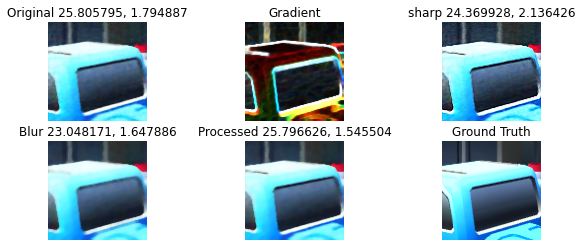

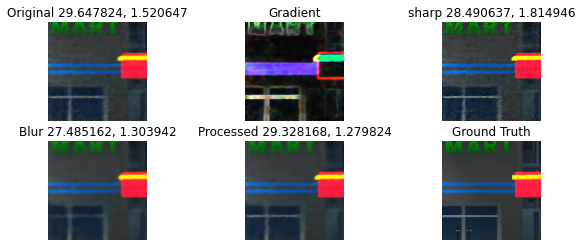

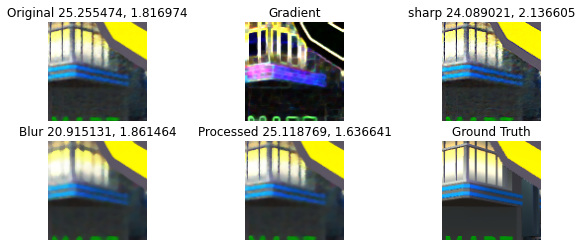

In [2]:
# 图像去噪平滑滤波
# 使用opencv的自带函数实现，与自编写作比较
# 产生椒盐噪声，高斯噪声等
# 使用中值滤波，平均滤波，高斯滤波，方框滤波
import sys
import os
sys.path.append(os.path.abspath(sys.path[0] + '/../../'))
__package__ = "deep_view_syn.notebook"

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as nn_f
import torch
from ..loss.perc_loss import *

loss = VGGPerceptualLoss().to('cuda')

def psnr(input, gt):
    input, gt = torch.from_numpy(input / 255).permute(2, 0, 1)[None, :].to('cuda', torch.float32), torch.from_numpy(gt / 255).permute(2, 0, 1)[None, :].to('cuda', torch.float32)
    rmse = math.sqrt(nn_f.mse_loss(input, gt))
    #diff = target / 255 - ref / 255
    #rmse = math.sqrt(np.mean(diff ** 2.))
    #return rmse
    return 20 * math.log10(1.0 / rmse), loss(input, gt)


for i in range(3):
    image_gt = cv2.imread('/home/dengnc/deep_view_syn/data/gas_fovea_2020.12.31/train/view_%04d.png' % i)
    image = cv2.imread('/home/dengnc/deep_view_syn/data/gas_fovea_2020.12.31/new_fovea_rgb@nmsl-rgb_e10_fc128x4_d1-50_s32/output/model-epoch_300/train/out_view_%04d.png' % i)
    plt.figure(facecolor='white', figsize=(10,4))
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    mse, vgg = psnr(image, image_gt)
    plt.title('Original %f, %f' % (mse, vgg))

    xgrd = cv2.Sobel(image,cv2.CV_32FC1,1,0) / 4 / 255
    ygrd = cv2.Sobel(image,cv2.CV_32FC1,0,1) / 4 / 255
    grd = np.sqrt(xgrd ** 2 + ygrd ** 2) * 3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    grd = cv2.morphologyEx(grd,cv2.MORPH_CLOSE, kernel)
    grd = np.clip(grd, 0, 1)
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(grd, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Gradient')

    kernel = np.array([[0, -0.3, 0], [-0.3, 2.2, -0.3], [0, -0.3, 0]], np.float32) #定义一个核
    sharp = cv2.filter2D(image, -1, kernel=kernel)
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    mse, vgg = psnr(sharp, image_gt)
    plt.title('sharp %f, %f' % (mse, vgg))

    # 中值滤波
    blur = cv2.medianBlur(image, 5)
    #blur = cv2.GaussianBlur(image, (3, 3), 0)
    #result4 = cv2.fastNlMeansDenoisingColored(result4,None,5,5,7,21)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    mse, vgg = psnr(blur, image_gt)
    plt.title('Blur %f, %f' % (mse, vgg))

    result = blur * (1 - grd) + image * grd
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(result / 255, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    mse, vgg = psnr(result, image_gt)
    plt.title('Processed %f, %f' % (mse, vgg))

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(image_gt, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Ground Truth')

    plt.show()

